In [1]:
import warnings
warnings.simplefilter(action='ignore',)

import numpy as np
import pandas as pd
from math import gcd
import matplotlib.pyplot as plt

from qiskit import BasicAer, QuantumCircuit,execute
from qiskit.quantum_info import Operator
backend = BasicAer.get_backend("qasm_simulator")

from qiskit.visualization import plot_histogram

#### Factorizing

In [2]:
N = 15
a = 13

if gcd(N,a) == 1: print(f'N and a is co-prime')
else: print(f'N and a is not co-prime, choose a again')

N and a is co-prime


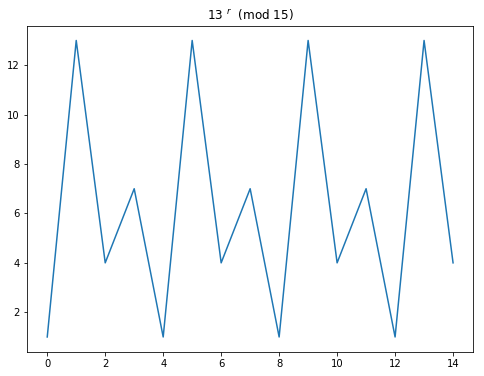

In [3]:
r = list(range(N))
y = [a**r_i % N for r_i in r]

plt.figure(figsize=(8,6))
plt.plot(r,y)
plt.title(f'{a} $^r$  (mod {N})')
plt.show()

In [4]:
rr = r[y[1:].index(1)+1]
if rr % 2 == 0:
    x = int(a**(rr/2) % N)
    print(f'r = {rr} is even, x={x}')
else:
    print(f'r = {rr} is not even, choose a again')

r = 4 is even, x=4


In [5]:
if x+1 % N != 0: print(str(gcd(int(x)+1,N)) + " and " + str(gcd(int(x)-1,N)))
else: print(f'x + 1 = 0 (mod N)')

5 and 3


In [6]:
# QFT dagger

def phase_rotate(circuit, n):  
    if n == 0: return circuit    
    n = n-1
    circuit.h(n)    
    for qubit in range(n): circuit.cp(np.pi/2**(n-qubit), qubit, n)     
    phase_rotate(circuit, n)

def swap_registers(circuit, n):    
    for qubit in range(n//2): circuit.swap(qubit, n-qubit-1)

def qft_dagger(circuit, n): 
    qc = QuantumCircuit(n)
    phase_rotate(qc,n)
    swap_registers(qc,n)
    
    qc_dagger = qc.inverse()
    qft_dagger = qc_dagger.to_gate()
    qft_dagger.name = " QFT$^\dagger$ "
    circuit.append(qft_dagger, range(n))

In [7]:
def c_amod15(a, power):
    
    if a not in [2,4,7,8,11,13]: raise ValueError("'a' must be 2,4,7,8,11,13")
        
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

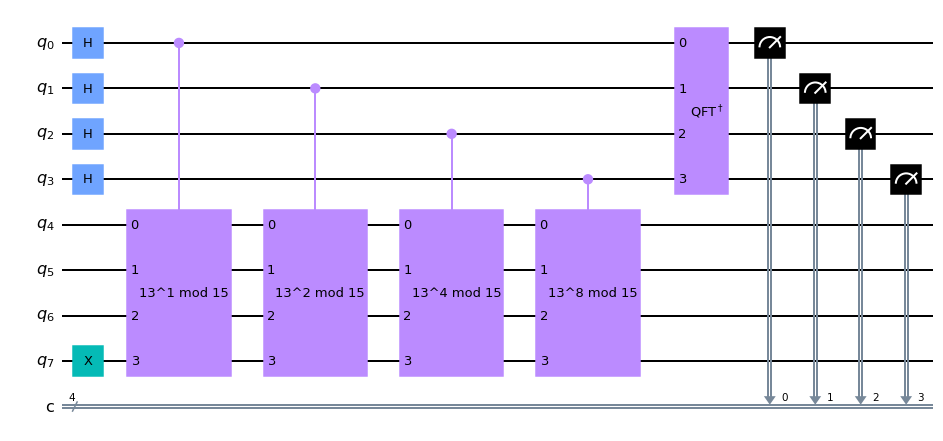

In [8]:
QUBITS = 4
a = 13

qc = QuantumCircuit(QUBITS + 4, QUBITS)
qc.h(range(QUBITS))
    
# And auxiliary register in state |1>
qc.x(3+QUBITS)

# Do controlled-U operations
for q in range(QUBITS): qc.append(c_amod15(a, 2**q), [q] + [i+QUBITS for i in range(4)])

qft_dagger(qc,QUBITS)
qc.measure(range(QUBITS), range(QUBITS))
qc.draw(fold=-1, output="mpl")  

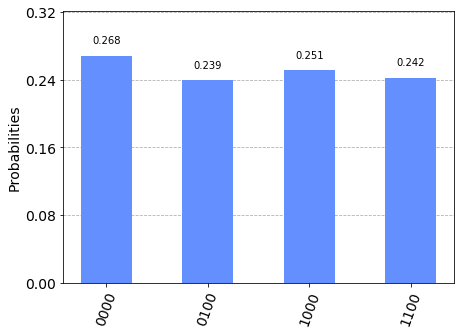

In [9]:
result = execute(qc, backend=backend,shots=1024).result()
counts = result.get_counts()
plot_histogram(counts)

In [10]:
from fractions import Fraction

rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  
    phase = decimal/(2**QUBITS) 
    measured_phases.append(phase)

    
    frac = Fraction(phase).limit_denominator(15)
    rows.append([f"{output} = {decimal:>3}", f"{decimal}/{2**QUBITS} = {phase:.2f}",f"{frac.numerator}/{frac.denominator}", frac.denominator])
    
headers=["Register Output", "Phase", "Fraction", "Guess"]
df = pd.DataFrame(rows, columns=headers)
print(df)

R = df['Guess'].value_counts().idxmax() # 頻率最高

print("\nR =",R,"\n")
X = int(a**(R/2) % N)
if X+1 % N != 0: print("The factors of " + str(N) + " are " + str(gcd(int(X)+1,N)) + " and " + str(gcd(int(X)-1,N)))
else: print(f'x + 1 = 0 (mod N)')

  Register Output         Phase Fraction  Guess
0      0000 =   0   0/16 = 0.00      0/1      1
1      0100 =   4   4/16 = 0.25      1/4      4
2      1000 =   8   8/16 = 0.50      1/2      2
3      1100 =  12  12/16 = 0.75      3/4      4

R = 4 

The factors of 15 are 5 and 3


#### Qiskit built-in Shor's algorithm

In [11]:
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Shor
from qiskit import Aer
from time import time

start_time = time()

N = 15
backend = Aer.get_backend('aer_simulator') # 用別的會跑很久
quantum_instance = QuantumInstance(backend, shots=1024)
shor = Shor(quantum_instance=quantum_instance)
result = shor.factor(N)

end_time = time()
print("Cost time:", round(end_time-start_time,2),"s")
print(f"The factors of {N} are {result.factors[0]}.")

Cost time: 17.67 s
The factors of 15 are [3, 5].
